In [1]:
# Importing the imporant libraries that will be used thoughout the notebook
import pandas as pd
import numpy as np
from IPython.display import display

import matplotlib.pyplot as plt
import re
import string

import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
#from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
nltk.download('stopwords')
nltk.download('vader_lexicon')


from collections import Counter

from matplotlib import pyplot as plt
from matplotlib import ticker
import seaborn as sns
import plotly.express as px

sns.set(style="darkgrid")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


### Data Collection

In [10]:
# reading data from csv file
df = pd.read_csv("/content/EndSars_datasets - NigeriaEndSars data.csv.csv")
df = df[:5000]
needed_columns=['username','date','content','Labels']
df=df[needed_columns]
df.head()

,username,date,content,Labels
0,hurbhiaghelee,2021-04-22 18:28:26+00:00,This is the highest form of intimidation\nWhat...,Neutral
1,AlukoJoseph5,2021-04-22 15:07:05+00:00,Why is it taking a life long time for @MBuhari...,Positive
2,omofuma_Elijah,2021-04-22 10:13:20+00:00,"Even Desmond Elliot is quite , ,,, what is tha...",Negative
3,FelixOdohoedi,2021-04-22 09:48:04+00:00,When will CBN freeze the account of @DrIsaPant...,Positive
4,adekzee1,2021-04-22 09:31:40+00:00,@Obiejazzyup @YeleSowore @MBuhari @EndSars @mb...,Positive


In [11]:
df.isnull().sum()

username    0
date        0
content     0
Labels      0
dtype: int64

In [12]:
# convert username type from object to category for assigning the numbers after it
df.username=df.username.astype('category')
df.username=df.username.cat.codes # assign a unique numerical code to each category
df.date=pd.to_datetime(df.date).dt.date # it will give only the date
# assigning content column to 'texts' variable
texts=df.content

### Data Preprocessing

In [13]:
#Removing URLS from tweets
remove_url=lambda x:re.sub(r'http\S+','',str(x))

#converting to all tweets to lowercase
to_lower=lambda x: x.lower()

#Removing punctuations
remove_puncs= lambda x:x.translate(str.maketrans('','',string.punctuation))

#Removing stopwords
more_words=["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]
stop_words=set(stopwords.words('english')) #nltk package
stop_words.update(more_words)

remove_words=lambda x: ' '.join([word for word in x.split() if word not in stop_words]) #.join is from package string


texts_lr=texts.apply(remove_url)
texts_lr_lc=texts_lr.apply(to_lower)
texts_lr_lc_np=texts_lr_lc.apply(remove_puncs)
texts_lr_lc_np_ns=r=texts_lr_lc_np.apply(remove_words)
df['content'] = texts_lr_lc_np_ns

**Putting Cleaned Text in the main Df**

In [14]:
display(df.head(5))
df.text=texts_lr_lc_np_ns
display(df.head(5))

,username,date,content,Labels
0,2707,2021-04-22,highest form intimidation offence commit give ...,Neutral
1,210,2021-04-22,taking life long time mbuhari sack drisapantam...,Positive
2,3149,2021-04-22,even desmond elliot quite womans name look lik...,Negative
3,796,2021-04-22,cbn freeze account drisapantami cbn quick free...,Positive
4,2257,2021-04-22,obiejazzyup yelesowore mbuhari endsars mbujari...,Positive


<ipython-input-14-c81a93e8f59b>:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.text=texts_lr_lc_np_ns


,username,date,content,Labels
0,2707,2021-04-22,highest form intimidation offence commit give ...,Neutral
1,210,2021-04-22,taking life long time mbuhari sack drisapantam...,Positive
2,3149,2021-04-22,even desmond elliot quite womans name look lik...,Negative
3,796,2021-04-22,cbn freeze account drisapantami cbn quick free...,Positive
4,2257,2021-04-22,obiejazzyup yelesowore mbuhari endsars mbujari...,Positive


**Additional Data Cleaning**

In [15]:
def clean_text(text):
    '''remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text
df['content'] = df['content'].apply(lambda x: clean_text(x))

In [16]:
# function to remove emoticons, symbols or flags by their codes
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
df['content']=df['content'].apply(lambda x: remove_emoji(x))

In [17]:
df

,username,date,content,Labels
0,2707,2021-04-22,highest form intimidation offence commit give ...,Neutral
1,210,2021-04-22,taking life long time mbuhari sack drisapantam...,Positive
2,3149,2021-04-22,even desmond elliot quite womans name look lik...,Negative
3,796,2021-04-22,cbn freeze account drisapantami cbn quick free...,Positive
4,2257,2021-04-22,obiejazzyup yelesowore mbuhari endsars mbujari...,Positive
...,...,...,...,...
4995,2574,2020-10-18,libertadorbayo endsars,Neutral
4996,837,2020-10-18,endsars,Neutral
4997,1316,2020-10-18,big thanks various celebrity naija youth came ...,Positive
4998,1579,2020-10-18,benomohp atiku endsars,Neutral


### Annotations/Sentiment Analysis


In [ ]:
# getting polarity scores of tweets and storing them in variable 'sentiment_scores'
sid=SentimentIntensityAnalyzer()
ps=lambda x:sid.polarity_scores(x)
sentiment_scores=df.content.apply(ps)
sentiment_scores

0       {'neg': 0.248, 'neu': 0.644, 'pos': 0.109, 'co...
1       {'neg': 0.305, 'neu': 0.495, 'pos': 0.201, 'co...
2       {'neg': 0.152, 'neu': 0.758, 'pos': 0.09, 'com...
3       {'neg': 0.177, 'neu': 0.731, 'pos': 0.092, 'co...
4       {'neg': 0.184, 'neu': 0.559, 'pos': 0.257, 'co...
                              ...                        
9732    {'neg': 0.09, 'neu': 0.667, 'pos': 0.242, 'com...
9733    {'neg': 0.149, 'neu': 0.851, 'pos': 0.0, 'comp...
9734    {'neg': 0.0, 'neu': 0.828, 'pos': 0.172, 'comp...
9735    {'neg': 0.35, 'neu': 0.504, 'pos': 0.146, 'com...
9736    {'neg': 0.17, 'neu': 0.764, 'pos': 0.066, 'com...
Name: content, Length: 9737, dtype: object

In [ ]:
# create the data frame of negative, neutral, positive and compound polarity scores
sentiment_df=pd.DataFrame(data=list(sentiment_scores))
labelize=lambda x:'neutral' if x==0 else('positive' if x>0 else 'negative')
sentiment_df['label']=sentiment_df.compound.apply(labelize)
display(sentiment_df.head(10))

,neg,neu,pos,compound,label
0,0.248,0.644,0.109,-0.4215,negative
1,0.305,0.495,0.201,-0.7003,negative
2,0.152,0.758,0.090,-0.1779,negative
3,0.177,0.731,0.092,-0.6369,negative
4,0.184,0.559,0.257,0.3818,positive
5,0.269,0.493,0.238,-0.1779,negative
6,0.000,1.000,0.000,0.0000,neutral
7,0.407,0.543,0.050,-0.7845,negative
8,0.220,0.680,0.100,-0.4588,negative
9,0.000,1.000,0.000,0.0000,neutral


In [ ]:
data=df.join(sentiment_df.label)
sentiment_df = df.join(sentiment_df)
display(data.head(5))

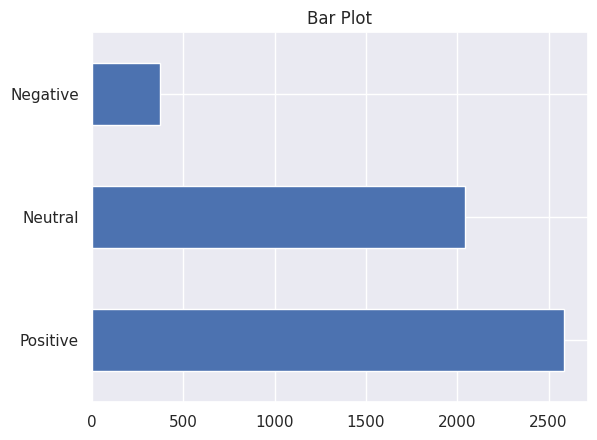

In [19]:
df['Labels'].value_counts().plot(kind='barh',title="Bar Plot");

In [20]:
df_agg = df.groupby(['date','Labels']).count().drop(['content'],axis=1).rename(columns={'username':'counts'})
df_agg = df_agg.reset_index()

In [21]:
neg = df_agg[df_agg['Labels']=='Negative']
pos = df_agg[df_agg['Labels']=='Positive']
neu = df_agg[df_agg['Labels']=='Neutral']

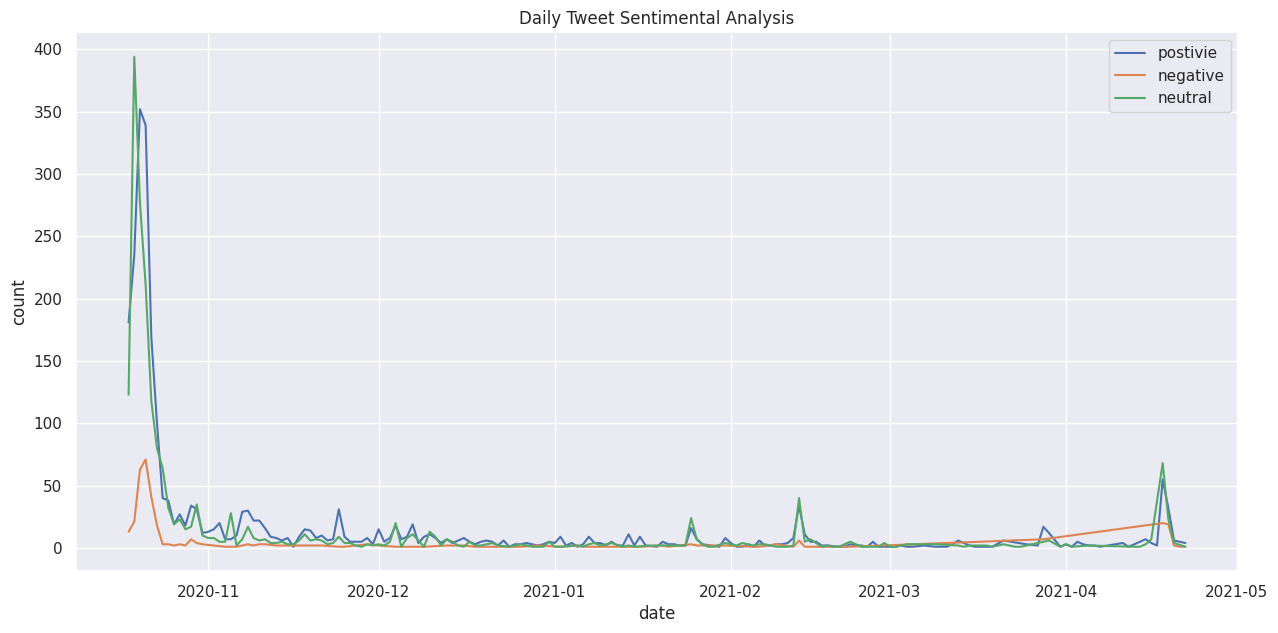

In [22]:
# px.line(data_agg,x='date',y='counts',color='label',title='Daily Tweet Sentimental Analysis')
fig = plt.figure(figsize = (15, 7))
plt.plot(pos['date'],pos['counts'], label='postivie')
plt.plot(neg['date'],neg['counts'], label='negative')
plt.plot(neu['date'],neu['counts'], label='neutral')

# Add labels and title
plt.title("Daily Tweet Sentimental Analysis")
plt.xlabel("date")
plt.ylabel("count")
plt.legend()
plt.show()

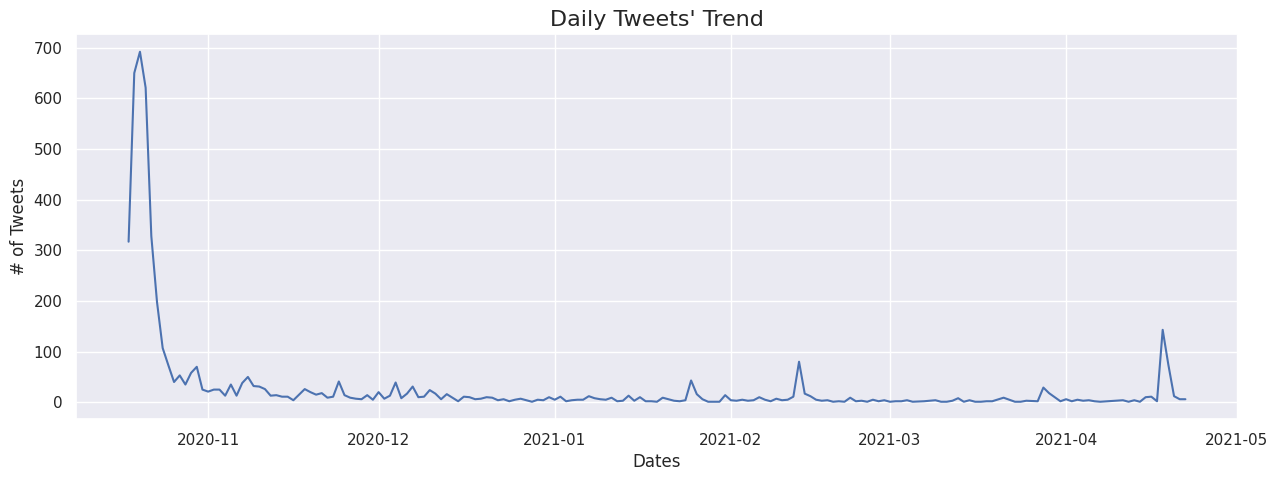

In [23]:
daily_tweets = df.groupby(['date'])['content'].count()

fig = plt.figure(figsize = (15,5))
plt.plot(daily_tweets.index,daily_tweets.values)
plt.title('Daily Tweets\' Trend', fontsize=16)
plt.xlabel('Dates')
plt.ylabel('# of Tweets')
plt.show()

**WordCloud**

In [24]:
from wordcloud import WordCloud

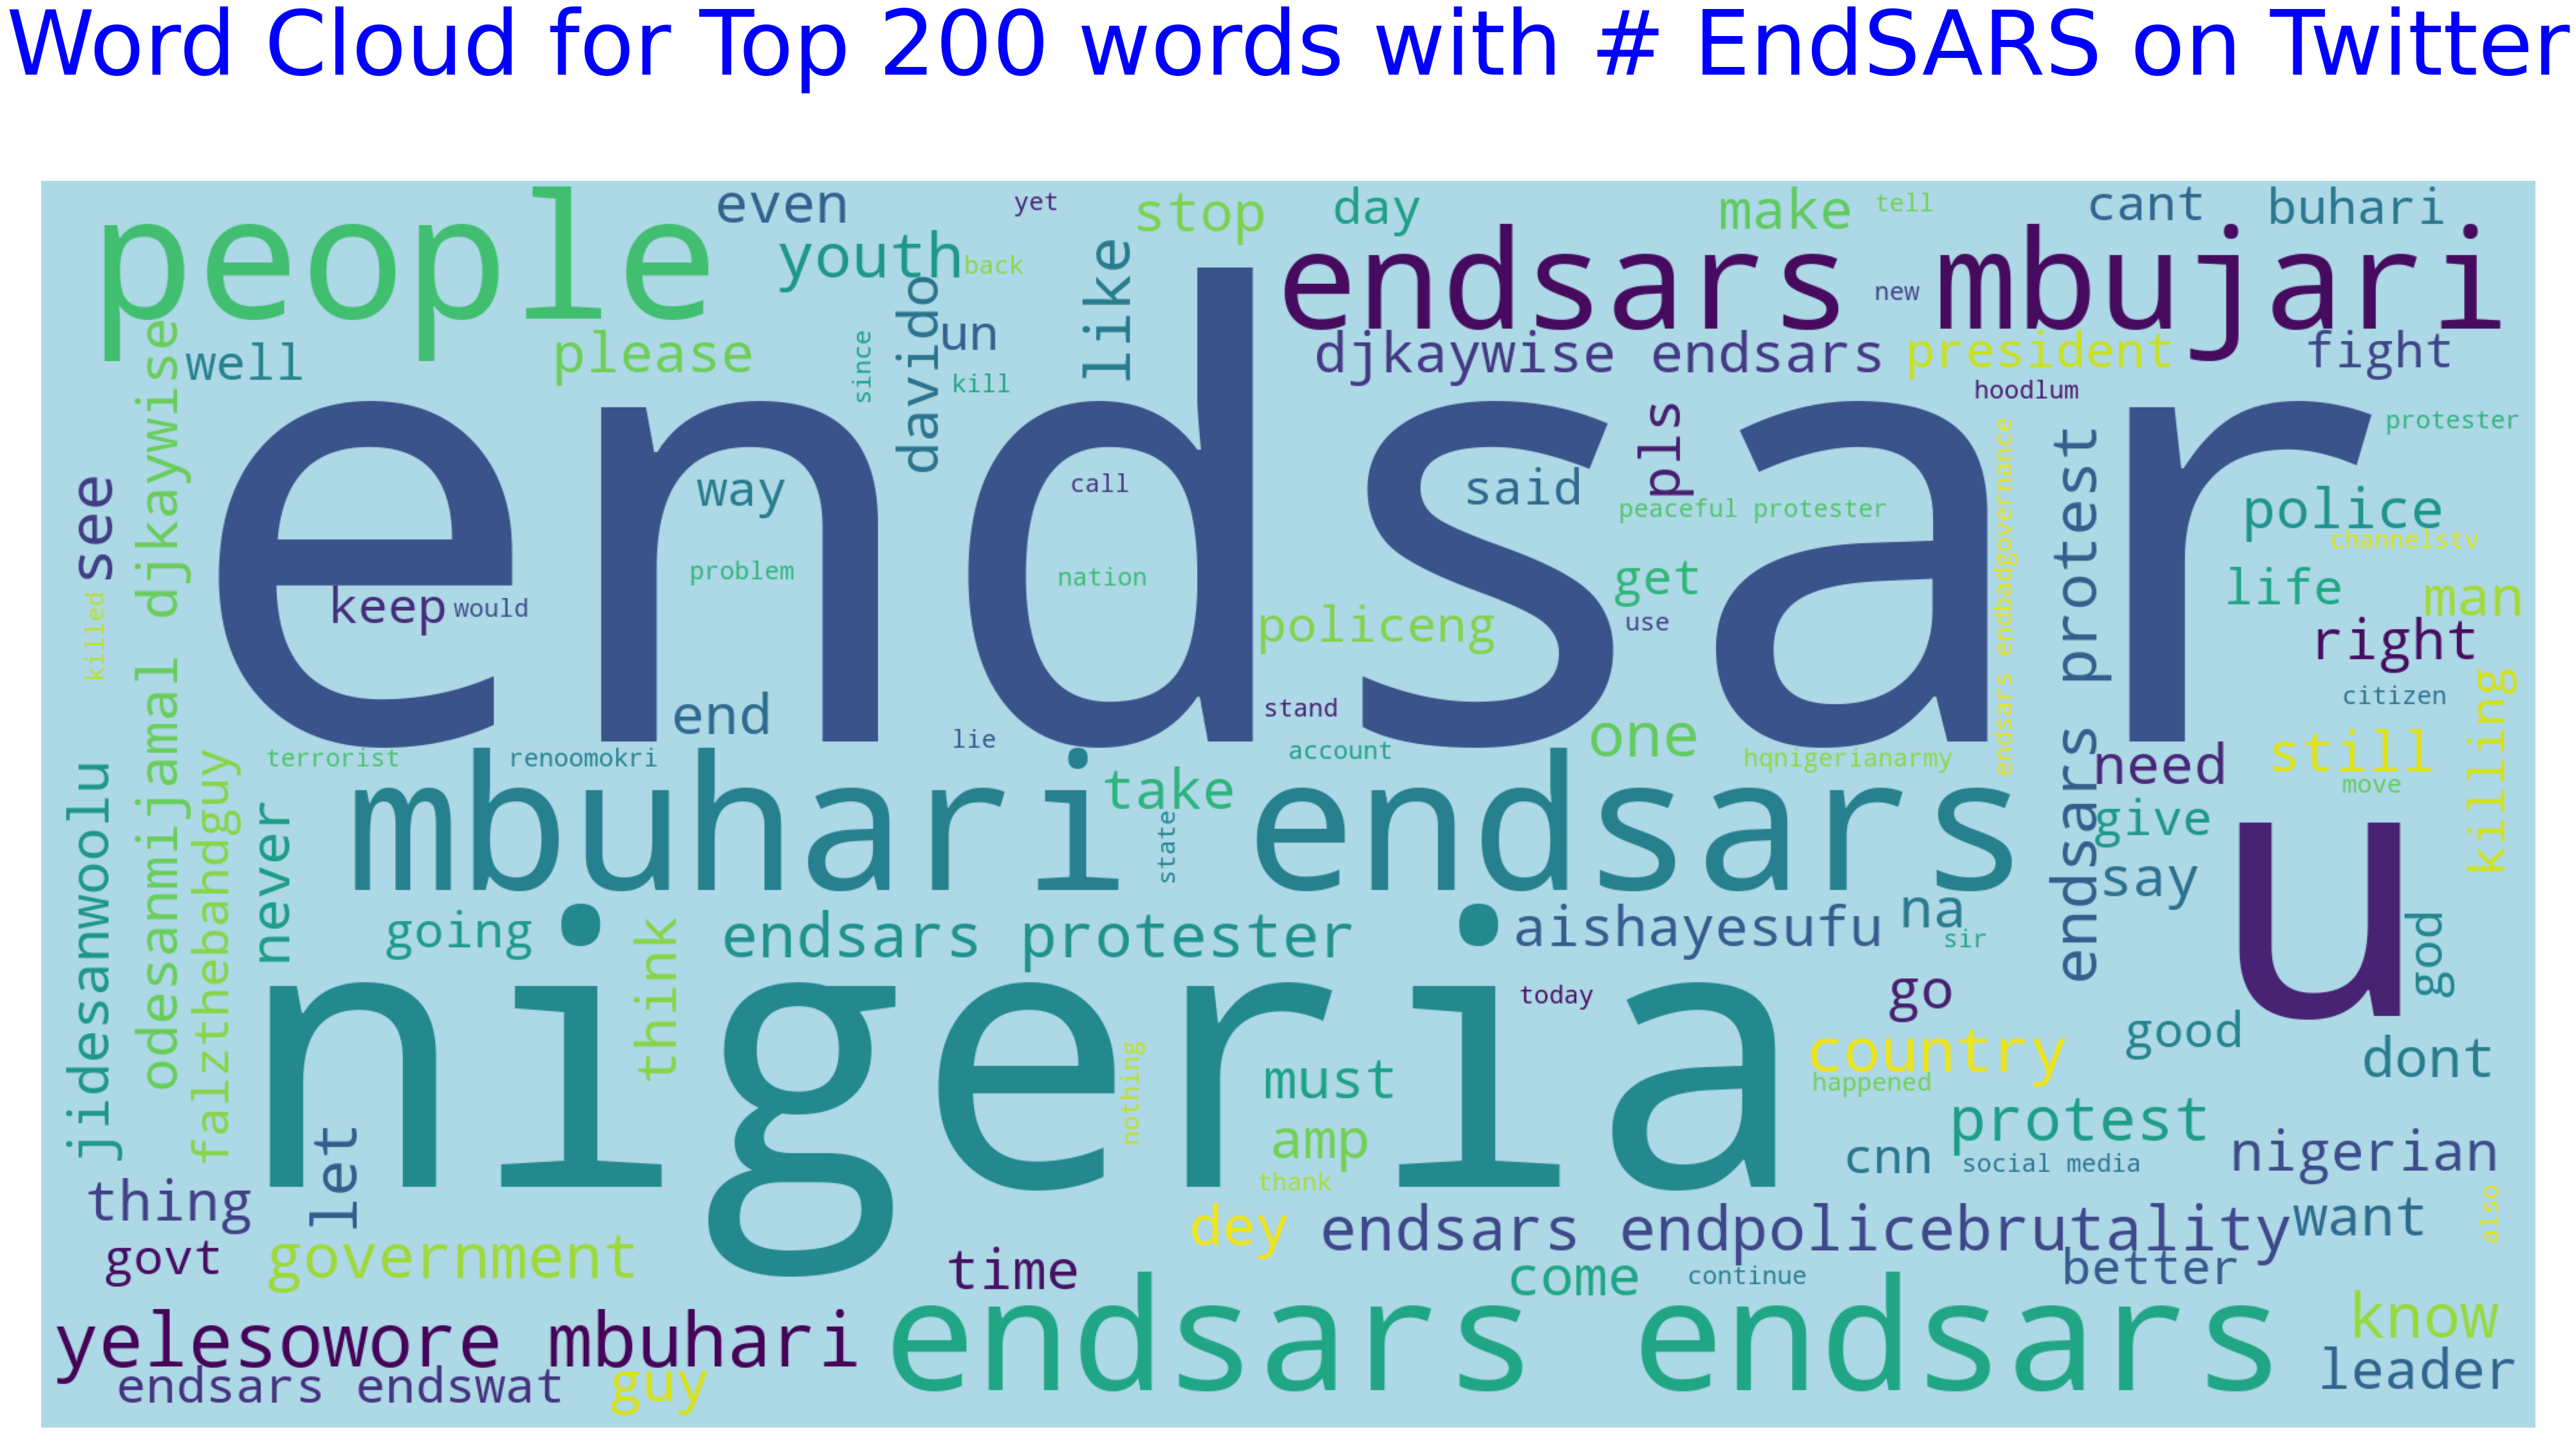

In [25]:
cut_text = " ".join(df.text)
max_words=200
word_cloud = WordCloud(
                    background_color='lightblue',
                    stopwords=set(stop_words),
                    max_words=max_words,
                    max_font_size= 100,
                    relative_scaling=0.5,
                    scale=5,
    colormap='viridis',
                    random_state=1).generate(cut_text)
fig = plt.figure(1, figsize=(50,50))
plt.axis('off')
plt.title('Word Cloud for Top '+str(max_words)+' words with # EndSARS on Twitter\n', fontsize=100,color='blue')
fig.subplots_adjust(top=2.3)
plt.imshow(word_cloud)
plt.show()

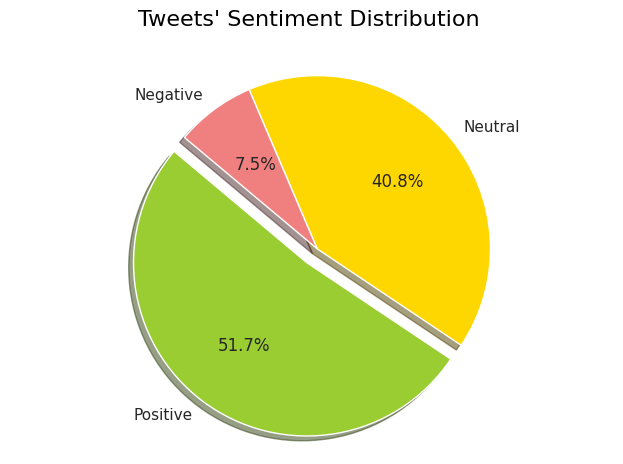

In [26]:
sentiment_dist = df.Labels.value_counts()

plt.pie(sentiment_dist, labels=sentiment_dist.index, explode= (0.1,0,0),
        colors=['yellowgreen', 'gold', 'lightcoral'],
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.title("Tweets\' Sentiment Distribution \n", fontsize=16, color='Black')
plt.axis('equal')
plt.tight_layout()
plt.show()

### Feature Extraction

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold, StratifiedShuffleSplit, StratifiedKFold
from sklearn.preprocessing import LabelEncoder

vectorizer = TfidfVectorizer(sublinear_tf=True)
labelEnc = LabelEncoder()

In [30]:
# train, test = train_test_split(data, test_size=0.2, random_state=0)

X = df['content']
y = df['Labels']

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
for train_index, test_index in splitter.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Model Development

In [31]:
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

In [32]:
svm_class = SVC(C=250, # penalty parameter, setting it to a larger value
                kernel='rbf', # kernel type, rbf working fine here
                gamma=1.4, # kernel coefficient, not tuned yet
                coef0=1, # change to 1 from default value of 0.0
                cache_size=1000, # 200 MB cache size
                random_state=0)

log_class = LogisticRegression(max_iter=1000,random_state=0)
gnb_class = GaussianNB()
voting_class = VotingClassifier(estimators=[
    ('Support_Vector_Machines', svm_class), ('logistic_regression', log_class)], voting='hard', verbose=True)

In [33]:
def eval_metrics(labels, preds, class_names):
    acc = accuracy_score(labels, preds)
    prec = precision_score(labels, preds,average="macro")
    rec = recall_score(labels, preds,average="macro")
    f1_sc = f1_score(labels, preds,average="macro")
    report = classification_report(labels, preds, target_names=class_names.keys())

    print(f"Acc: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}, f1_Score: {f1_sc:.3f}")
    return report

### Model Training and Testing

In [34]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
svm_oof_preds = []
mean_f1 = []

X_skf = X_train.reset_index(drop=True)
y_skf = y_train.reset_index(drop=True)

for train_index, test_index in skf.split(X_skf, y_skf):
    X_train_skf, X_test_skf = X.iloc[train_index], X.iloc[test_index]
    y_train_skf, y_test_skf = y.iloc[train_index], y.iloc[test_index]

    # Extracting Features
    X_train_skf = vectorizer.fit_transform(X_train_skf.values)
    X_test_skf = vectorizer.transform(X_test_skf.values)

    # Encoding target Variables
    y_train_skf = labelEnc.fit_transform(y_train_skf.values)
    y_test_skf = labelEnc.fit_transform(y_test_skf.values)
    classes = dict(zip(labelEnc.classes_, labelEnc.transform(labelEnc.classes_)))

    # Training and Testing
    svm_class.fit(X_train_skf, y_train_skf)
    preds = svm_class.predict(X_test_skf)
    score = f1_score(y_test_skf, preds, average="macro")
    svm_report = eval_metrics(y_test_skf, preds, classes)
    mean_f1.append(score)

    # Test predictions
    X_test_main = vectorizer.transform(X_test.values)
    testpreds = svm_class.predict(X_test_main)
    svm_oof_preds.append(testpreds)

f1_fold = np.mean(mean_f1)
print(f"StratifiedKFold 5 Splits Mean: {f1_fold:.3f}")


Acc: 0.728, Precision: 0.662, Recall: 0.528, f1_Score: 0.517
Acc: 0.757, Precision: 0.781, Recall: 0.551, f1_Score: 0.554
Acc: 0.769, Precision: 0.852, Recall: 0.566, f1_Score: 0.574
Acc: 0.745, Precision: 0.790, Recall: 0.561, f1_Score: 0.574
Acc: 0.754, Precision: 0.847, Recall: 0.552, f1_Score: 0.557
StratifiedKFold 5 Splits Mean: 0.555


In [35]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
log_oof_preds = []
mean_f1 = []

X_skf = X_train.reset_index(drop=True)
y_skf = y_train.reset_index(drop=True)

for train_index, test_index in skf.split(X_skf, y_skf):
    X_train_skf, X_test_skf = X.iloc[train_index], X.iloc[test_index]
    y_train_skf, y_test_skf = y.iloc[train_index], y.iloc[test_index]

    # Extracting Features
    X_train_skf = vectorizer.fit_transform(X_train_skf.values)
    X_test_skf = vectorizer.transform(X_test_skf.values)

    # Encoding target Variables
    y_train_skf = labelEnc.fit_transform(y_train_skf.values)
    y_test_skf = labelEnc.fit_transform(y_test_skf.values)
    classes = dict(zip(labelEnc.classes_, labelEnc.transform(labelEnc.classes_)))

    # Training and Testing
    log_class.fit(X_train_skf, y_train_skf)
    preds = log_class.predict(X_test_skf)
    score = f1_score(y_test_skf, preds, average="macro")
    svm_report = eval_metrics(y_test_skf, preds, classes)
    mean_f1.append(score)

    # Test predictions
    X_test_main = vectorizer.transform(X_test.values)
    testpreds = log_class.predict(X_test_main)
    log_oof_preds.append(testpreds)

f1_fold = np.mean(mean_f1)
print(f"StratifiedKFold 5 Splits Mean: {f1_fold:.3f}")


Acc: 0.730, Precision: 0.660, Recall: 0.528, f1_Score: 0.512
Acc: 0.767, Precision: 0.794, Recall: 0.565, f1_Score: 0.571
Acc: 0.766, Precision: 0.781, Recall: 0.563, f1_Score: 0.564
Acc: 0.743, Precision: 0.825, Recall: 0.553, f1_Score: 0.559
Acc: 0.745, Precision: 0.836, Recall: 0.538, f1_Score: 0.532
StratifiedKFold 5 Splits Mean: 0.548


In [36]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
gnb_oof_preds = []
mean_f1 = []

X_skf = X_train.reset_index(drop=True)
y_skf = y_train.reset_index(drop=True)

for train_index, test_index in skf.split(X_skf, y_skf):
    X_train_skf, X_test_skf = X.iloc[train_index], X.iloc[test_index]
    y_train_skf, y_test_skf = y.iloc[train_index], y.iloc[test_index]

    # Extracting Features
    X_train_skf = vectorizer.fit_transform(X_train_skf.values)
    X_test_skf = vectorizer.transform(X_test_skf.values)

    # Encoding target Variables
    y_train_skf = labelEnc.fit_transform(y_train_skf.values)
    y_test_skf = labelEnc.fit_transform(y_test_skf.values)
    classes = dict(zip(labelEnc.classes_, labelEnc.transform(labelEnc.classes_)))

    # Training and Testing
    gnb_class.fit(X_train_skf.toarray(), y_train_skf)
    preds = gnb_class.predict(X_test_skf.toarray())
    score = f1_score(y_test_skf, preds, average="macro")
    svm_report = eval_metrics(y_test_skf, preds, classes)
    mean_f1.append(score)

    # Test predictions
    X_test_main = vectorizer.transform(X_test.values)
    testpreds = gnb_class.predict(X_test_main.toarray())
    gnb_oof_preds.append(testpreds)

f1_fold = np.mean(mean_f1)
print(f"StratifiedKFold 5 Splits Mean: {f1_fold:.3f}")


Acc: 0.559, Precision: 0.465, Recall: 0.461, f1_Score: 0.450
Acc: 0.604, Precision: 0.499, Recall: 0.485, f1_Score: 0.471
Acc: 0.610, Precision: 0.503, Recall: 0.494, f1_Score: 0.483
Acc: 0.561, Precision: 0.462, Recall: 0.460, f1_Score: 0.445
Acc: 0.585, Precision: 0.499, Recall: 0.485, f1_Score: 0.468
StratifiedKFold 5 Splits Mean: 0.464


In [37]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
voting_oof_preds = []
mean_f1 = []

X_skf = X_train.reset_index(drop=True)
y_skf = y_train.reset_index(drop=True)

for train_index, test_index in skf.split(X_skf, y_skf):
    X_train_skf, X_test_skf = X.iloc[train_index], X.iloc[test_index]
    y_train_skf, y_test_skf = y.iloc[train_index], y.iloc[test_index]

    # Extracting Features
    X_train_skf = vectorizer.fit_transform(X_train_skf.values)
    X_test_skf = vectorizer.transform(X_test_skf.values)

    # Encoding target Variables
    y_train_skf = labelEnc.fit_transform(y_train_skf.values)
    y_test_skf = labelEnc.fit_transform(y_test_skf.values)
    classes = dict(zip(labelEnc.classes_, labelEnc.transform(labelEnc.classes_)))

    # Training and Testing
    voting_class.fit(X_train_skf, y_train_skf)
    preds = voting_class.predict(X_test_skf)
    score = f1_score(y_test_skf, preds, average="macro")
    svm_report = eval_metrics(y_test_skf, preds, classes)
    mean_f1.append(score)

    # Test predictions
    X_test_main = vectorizer.transform(X_test.values)
    testpreds = voting_class.predict(X_test_main)
    voting_oof_preds.append(testpreds)

f1_fold = np.mean(mean_f1)
print(f"StratifiedKFold 5 Splits Mean: {f1_fold:.3f}")


[Voting] .. (1 of 2) Processing Support_Vector_Machines, total=   2.2s
[Voting] ...... (2 of 2) Processing logistic_regression, total=   0.7s
Acc: 0.728, Precision: 0.657, Recall: 0.531, f1_Score: 0.519
[Voting] .. (1 of 2) Processing Support_Vector_Machines, total=   2.2s
[Voting] ...... (2 of 2) Processing logistic_regression, total=   1.1s
Acc: 0.774, Precision: 0.769, Recall: 0.576, f1_Score: 0.584
[Voting] .. (1 of 2) Processing Support_Vector_Machines, total=   3.0s
[Voting] ...... (2 of 2) Processing logistic_regression, total=   1.7s
Acc: 0.772, Precision: 0.807, Recall: 0.582, f1_Score: 0.595
[Voting] .. (1 of 2) Processing Support_Vector_Machines, total=   2.1s
[Voting] ...... (2 of 2) Processing logistic_regression, total=   0.8s
Acc: 0.746, Precision: 0.792, Recall: 0.570, f1_Score: 0.584
[Voting] .. (1 of 2) Processing Support_Vector_Machines, total=   2.2s
[Voting] ...... (2 of 2) Processing logistic_regression, total=   1.0s
Acc: 0.754, Precision: 0.840, Recall: 0.555, f

### Model Evaluation

In [38]:
y_test = labelEnc.fit_transform(y_test.values)
classes = dict(zip(labelEnc.classes_, labelEnc.transform(labelEnc.classes_)))

#### SVM CLASSIFIER

In [39]:
mean_preds = np.mean(svm_oof_preds,axis=0)
round_preds = np.round(mean_preds)

svm_report = eval_metrics(y_test, round_preds, classes)
print(svm_report)

Acc: 0.955, Precision: 0.968, Recall: 0.930, f1_Score: 0.947
              precision    recall  f1-score   support

    Negative       1.00      0.87      0.93        75
     Neutral       0.95      0.96      0.95       408
    Positive       0.95      0.97      0.96       517

    accuracy                           0.95      1000
   macro avg       0.97      0.93      0.95      1000
weighted avg       0.96      0.95      0.95      1000



#### LOGISTIC REGRESSION

In [40]:
mean_preds = np.mean(log_oof_preds,axis=0)
round_preds = np.round(mean_preds)

svm_report = eval_metrics(y_test, round_preds, classes)
print(svm_report)

Acc: 0.855, Precision: 0.906, Recall: 0.646, f1_Score: 0.660
              precision    recall  f1-score   support

    Negative       1.00      0.12      0.21        75
     Neutral       0.89      0.87      0.88       408
    Positive       0.83      0.95      0.89       517

    accuracy                           0.85      1000
   macro avg       0.91      0.65      0.66      1000
weighted avg       0.87      0.85      0.83      1000



#### NAIVE BAYES CLASSIFIER

In [41]:
mean_preds = np.mean(gnb_oof_preds,axis=0)
round_preds = np.round(mean_preds)

svm_report = eval_metrics(y_test, round_preds, classes)
print(svm_report)

Acc: 0.803, Precision: 0.720, Recall: 0.826, f1_Score: 0.729
              precision    recall  f1-score   support

    Negative       0.35      0.91      0.51        75
     Neutral       0.86      0.71      0.78       408
    Positive       0.95      0.86      0.90       517

    accuracy                           0.80      1000
   macro avg       0.72      0.83      0.73      1000
weighted avg       0.87      0.80      0.82      1000



#### VOTING CLASSIFIER (SUPPORT_VECTOR_MACHINES + LOGISTIC REGRESSION)

In [42]:
mean_preds = np.mean(voting_oof_preds,axis=0)
round_preds = np.round(mean_preds)

svm_report = eval_metrics(y_test, round_preds, classes)
print(svm_report)

Acc: 0.954, Precision: 0.966, Recall: 0.930, f1_Score: 0.947
              precision    recall  f1-score   support

    Negative       1.00      0.87      0.93        75
     Neutral       0.93      0.97      0.95       408
    Positive       0.97      0.95      0.96       517

    accuracy                           0.95      1000
   macro avg       0.97      0.93      0.95      1000
weighted avg       0.95      0.95      0.95      1000

